# Tokenizer + Rouge-L

In [11]:
!pip install rouge-score
from huggingface_hub import login
login()
!pip install nltk

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=27007dc869fd295556a569464f092ec650114c18e8bccc0e5a19ec0f16ddf89f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [12]:

from transformers import AutoTokenizer
from rouge_score import rouge_scorer
from nltk.stem.isri import ISRIStemmer  # Import ISRI stemmer

# Load tokenizer
model_name = "core42/jais-13b"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize ISRI Stemmer
stemmer = ISRIStemmer()

# Define a custom tokenizer class that applies both tokenization and stemming
class CustomTokenizer:
    def __init__(self, tokenizer, stemmer):
        self.tokenizer = tokenizer
        self.stemmer = stemmer

    def tokenize(self, text):
        words = text.split()  # Split into words first
        stemmed_words = [self.stemmer.stem(word) for word in words]  # Apply stemming
        print("Stemmed Words:", stemmed_words)  # Debugging line to check the stemmed words
        return self.tokenizer.tokenize(" ".join(stemmed_words))  # Tokenize the stemmed text

# Create an instance of our custom tokenizer
custom_tokenizer = CustomTokenizer(tokenizer, stemmer)

# Create the ROUGE scorer with our custom tokenizer
scorer = rouge_scorer.RougeScorer(['rougeL'], tokenizer=custom_tokenizer)

# Example strings
pred_str = 'السلام عليكم كيف حالك'
label_str = 'السلام عليكم صديقي كيف حالك'

# Compute ROUGE scores
scores = scorer.score(label_str, pred_str)

# Print the stemmed words to check if stemming occurs
for key, value in scores.items():
    print(f'{key}: {value}')




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Stemmed Words: ['سلم', 'علي', 'صدق', 'كيف', 'حلك']
Stemmed Words: ['سلم', 'علي', 'كيف', 'حلك']
rougeL: Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091)


# Lexical Similarity

In [14]:
import itertools
import numpy as np
import json


def compute_lexical_similarity(data):
    """Compute lexical similarity for each question, ignoring semantic clusters"""
    lexical_similarity_scores = {}

    for i, item in enumerate(data):
        question_id = f"q{i+1}"

        # Flatten all answers into a single list
        all_answers = []
        for answer_array in item.get("answers", []):
            all_answers.extend([ans.strip() for ans in answer_array if ans.strip()])



        # Compute pairwise ROUGE-L similarity scores across all answers
        rouge_l_scores = []
        for answer1, answer2 in itertools.combinations(all_answers, 2):
            scores = scorer.score(answer1, answer2)
            rouge_l_f1 = scores["rougeL"].fmeasure
            rouge_l_scores.append(rouge_l_f1)

        # Compute the average ROUGE-L score for the entire question
        if rouge_l_scores:  # Check if there are any pairs
            lexical_similarity = np.mean(rouge_l_scores)


        # Store a single lexical similarity score per question
        lexical_similarity_scores[question_id] = lexical_similarity

    return lexical_similarity_scores

def save_lexical_similarity_to_file(lexical_similarity_scores, data, file_path):
    """Save the lexical similarity results to a file"""
    with open(file_path, 'w', encoding='utf-8') as f:
        # Iterate through the data (questions)
        for i, item in enumerate(data):
            question_id = f"q{i+1}"

            if question_id not in lexical_similarity_scores:
                continue

            lexical_similarity = lexical_similarity_scores[question_id]
            question = item.get("question", "")

            f.write(f"Question: {question} (ID: {question_id})\n")

            # List all answers from all clusters for this question
            f.write("\n  All Answers:\n")
            answer_index = 1

            # Flatten all answers
            all_answers = []
            for answer_array in item.get("answers", []):
                all_answers.extend([ans.strip() for ans in answer_array if ans.strip()])

            # Write each answer
            for answer in all_answers:
                f.write(f"    {answer_index}. {answer}\n")
                answer_index += 1

            # Write the lexical similarity for the question
            f.write(f"\n  Average Lexical Similarity Across All Answers: {lexical_similarity:.4f}\n")
            f.write("-" * 50 + "\n")  # Divider between questions for clarity

    print(f"Results have been saved to {file_path}")


"""function is designed to fix common formatting issues in JSON strings to make them parseable"""
try:
    # Handle JSON that might need cleaning
    def clean_json_string(string):
        #Clean a JSON string to make it parseable.
        clean_str = string.strip()
        if not clean_str.startswith('['):
            clean_str = '[' + clean_str
        if not clean_str.endswith(']'):
            clean_str = clean_str + ']'

        # Replace trailing commas before brackets
        clean_str = clean_str.replace(',]', ']')
        clean_str = clean_str.replace(',\n]', '\n]')
        clean_str = clean_str.replace(',\r\n]', '\r\n]')

        return clean_str

    # Try to read from paste.txt first (your sample file)
    try:
        with open('paste.txt', 'r', encoding='utf-8') as f:
            content = f.read()

        # Clean and parse the content
        cleaned_content = clean_json_string(content)
        raw_data = json.loads(cleaned_content)
        print(f"Successfully loaded data from paste.txt with {len(raw_data)} questions")
    except FileNotFoundError:
        # Fall back to the original path if paste.txt is not found
        with open('/content/semantic_entropy_allam_xor_tydiqa_results.json', 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
            print(f"Successfully loaded data from original path with {len(raw_data)} questions")

    # Calculate lexical similarity scores across all answers for each question
    lexical_similarity_scores = compute_lexical_similarity(raw_data)
    print("Lexical similarity scores calculated successfully")

    # Save the results to a file
    output_file = "lexical_similarity_results.json"
    save_lexical_similarity_to_file(lexical_similarity_scores, raw_data, output_file)
except FileNotFoundError:
    print("Error: Data file not found. Please provide the correct file path.")
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON format in the data file: {str(e)}")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

Streaming output truncated to the last 5000 lines.
Stemmed Words: ['حاليا،', 'وجد', '27', 'دول', 'عضو', 'في', 'تحد', 'ورب']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['حاليا،', 'وجد', '27', 'دول', 'عضو', 'في', 'تحد', 'ورب']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['حاليا،', 'وجد', '27', 'دول', 'عضو', 'في', 'تحد', 'ورب']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول', 'عضو']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول', 'عضو']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27', 'دول']
Stemmed Words: ['27'

# length normalized predictive entropy

In [15]:
import math
import json


def calculate_length_normalized_predictive_entropy(texts, log_likelihoods, custom_tokenizer):
    """
    Calculate length-normalized predictive entropy using log_likelihood values.

    Args:
        texts: List of answer texts
        log_likelihoods: List of corresponding log likelihood values
        custom_tokenizer: Tokenizer for text normalization

    Returns:
        Length-normalized predictive entropy value
    """
    if not texts or not log_likelihoods or len(texts) != len(log_likelihoods):
        return 0

    # Prepare data with tokenized lengths
    processed_answers = []
    for text, log_likelihood in zip(texts, log_likelihoods):
        if not text:
            continue

        # Get token count using custom tokenizer
        tokens = custom_tokenizer.tokenize(text)
        token_length = max(1, len(tokens))  # Avoid division by zero

        processed_answers.append({
            "text": text,
            "log_likelihood": log_likelihood,
            "token_length": token_length
        })

    if not processed_answers:
        return 0

    # Calculate length-normalized entropy
    # Normalize log likelihoods by token count
    normalized_log_likelihoods = [
        answer["log_likelihood"] / answer["token_length"]
        for answer in processed_answers
    ]

    # Convert normalized log likelihoods to probabilities
    # Since these are already log probabilities, we just need to exponentiate
    exp_norm_log_likelihoods = [math.exp(norm_ll) for norm_ll in normalized_log_likelihoods]
    sum_norm_exp = sum(exp_norm_log_likelihoods)

    length_normalized_entropy = 0
    for i in range(len(processed_answers)):
        norm_prob = exp_norm_log_likelihoods[i] / sum_norm_exp
        if norm_prob > 0:  # Avoid log(0)
            length_normalized_entropy -= norm_prob * math.log2(norm_prob)

    return length_normalized_entropy

def process_data(data):

    """
    Process the data to calculate length-normalized entropy for each question.
    """
    results = {}

    for i, question_data in enumerate(data):
        question_id = f"q{i+1}"

        # Get the question
        question = question_data.get("question", "")

        # Extract all answer texts from the nested answer arrays
        all_answer_texts = []
        for answer_array in question_data.get("answers", []):
            all_answer_texts.extend([ans for ans in answer_array if ans])

        # Get log likelihoods
        log_likelihoods = question_data.get("log_likelihoods", [])

        # Make sure we have matching lengths, truncate if necessary
        min_length = min(len(all_answer_texts), len(log_likelihoods))
        all_answer_texts = all_answer_texts[:min_length]
        log_likelihoods = log_likelihoods[:min_length]

        # Calculate length-normalized entropy
        length_normalized_entropy = calculate_length_normalized_predictive_entropy(
            all_answer_texts, log_likelihoods, custom_tokenizer
        )

        # Store results
        results[question_id] = {
            "question": question,
            "length_normalized_entropy": length_normalized_entropy,
            "semantic_entropy": question_data.get("semantic_entropy")
        }

    return results

# Handle JSON that might need cleaning
def clean_json_string(string):
    """Clean a JSON string to make it parseable."""
    clean_str = string.strip()
    if not clean_str.startswith('['):
        clean_str = '[' + clean_str
    if not clean_str.endswith(']'):
        clean_str = clean_str + ']'

    # Replace trailing commas before brackets
    clean_str = clean_str.replace(',]', ']')
    clean_str = clean_str.replace(',\n]', '\n]')
    clean_str = clean_str.replace(',\r\n]', '\r\n]')

    return clean_str

# Main execution
try:
    # Define input and output file paths
    input_file_path = '/content/semantic_entropy_allam_xor_tydiqa_results.json'
    output_file_path = 'length_normalized_entropy_results.json'

    # Load data
    print(f"Loading data from {input_file_path}...")
    try:
        with open(input_file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Clean and parse the content
        cleaned_content = clean_json_string(content)
        data = json.loads(cleaned_content)
        print(f"Successfully loaded data with {len(data)} questions")
    except FileNotFoundError:
        # Try alternate path
        print(f"File not found")


    # Process the data
    print(f"Processing {len(data)} questions...")
    results = process_data(data)

    # Save results to file
    print(f"Saving results to {output_file_path}...")
    with open(output_file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"Results successfully saved to {output_file_path}")

    # Print a few examples for verification
    print("\nExample results:")
    for question_id, metrics in list(results.items())[:3]:
        print(f"\nQuestion: {metrics['question']}")
        print(f"Length-Normalized Entropy: {metrics['length_normalized_entropy']:.4f}")
        print(f"Semantic Entropy: {metrics['semantic_entropy']}")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

Streaming output truncated to the last 5000 lines.
Stemmed Words: ['فقط', 'دول', 'وحد', 'وهي', 'ملك', 'تحد']
Stemmed Words: ['ملك', 'تحد']
Stemmed Words: ['ملك', 'تحد']
Stemmed Words: ['ملك', 'تحد', 'هي', 'دول', 'وحد', 'التي', 'ملك', 'حدد', 'برة', 'مع', 'ايرلندا،', 'وهي', 'حدد', 'برة', 'دول']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'جورج', 'ريدر', 'هاندل', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'لند']
Stemmed Words: ['عاش', 'في', 'دين', 'هامبورج', 'لمن']
Stemmed Words: ['حكم', 'لمد', '80', 'يوم']
Stemmed Words: ['فتر', 'حكم', 'ملك', 'سيف', 'دين', 'قطز', 'دمت', '80', 'يوم']
Stemmed Words: ['حكم', 'لمد', '80', 'يوم']
Stemmed Words: ['فتر', 'حكم', 'ملك', 'سيف', 'دين', 'قطز', 'مرت', 'لمد', '80', 'يوم']
Stemmed Words: ['دام', 'حكم', 'ملك', 'سيف', 'دين', 'قط

# The clustering approach + Auroc + Barchart

Loading main data from /content/newWithSE_ALLAMXOR_rougel_isri.json...
Loading length normalized entropy data from /content/length_normalized_entropy_results.json...
Loading lexical similarity data from lexical_similarity_results.json...
Computing AUROC scores...

AUROC Results:
semantic_entropy: 0.6720
clustering_approach: 0.6679
predictive_entropy: 0.7352
length_normalized_entropy: 0.4482
lexical_similarity: 0.6050
ROC curves saved as 'all_metrics_roc_curve.png'


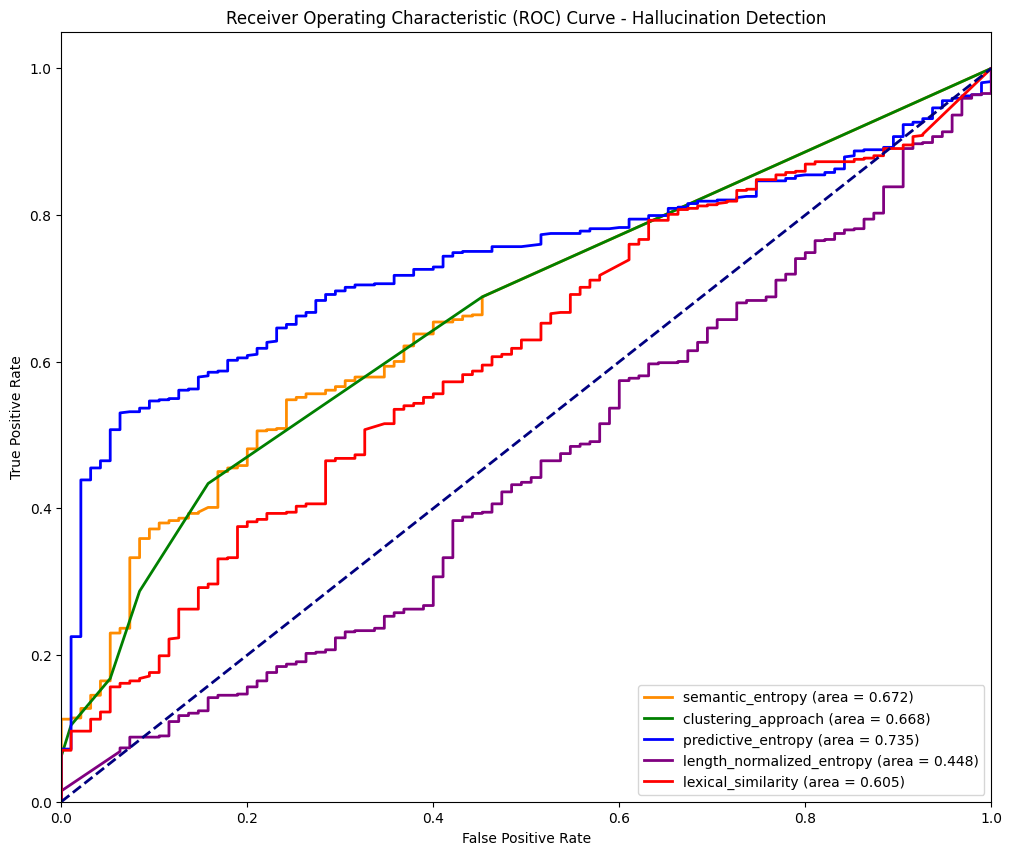

AUROC bar chart saved as 'auroc_barchart.png'


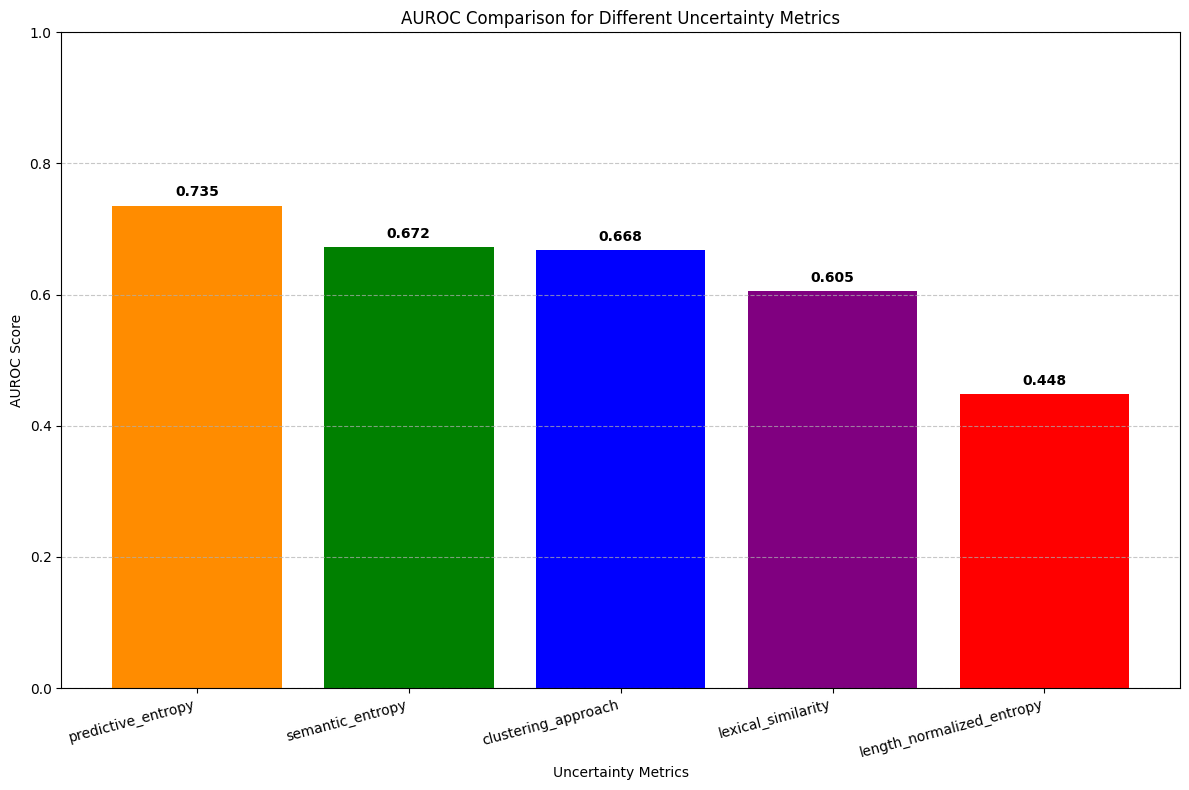


Results saved to 'auroc_results.json'


In [16]:
import json
import re
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

def load_data_from_json(file_path):
    """Load data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_length_normalized_entropy(file_path):
    """Extract length-normalized entropy values from JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Initialize dictionary to store the values
        length_normalized_dict = {}

        # Extract length_normalized_entropy for each question
        for question_id, question_data in data.items():
            length_normalized_dict[question_id] = {
                "question": question_data.get("question", ""),
                "length_normalized_entropy": question_data.get("length_normalized_entropy")
            }

        return length_normalized_dict
    except Exception as e:
        print(f"Error extracting length-normalized entropy from {file_path}: {e}")
        return {}

def extract_lexical_similarity_from_txt(file_path):
    """Extract lexical similarity scores from the text file."""
    lexical_similarity = {}
    pattern = r"Question: .+ \(ID: (q\d+)\)[\s\S]+?Average Lexical Similarity Across All Answers: ([\d.]+)"

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            matches = re.findall(pattern, content)

            for question_id, similarity in matches:
                lexical_similarity[question_id] = float(similarity)

            return lexical_similarity
    except Exception as e:
        print(f"Error extracting lexical similarity from {file_path}: {e}")
        return {}

def compute_auroc_for_metrics(main_data, length_normalized_data=None, lexical_similarity_data=None):
    """
    Compute AUROC for each uncertainty measure.

    Args:
        main_data: List containing question data with semantic entropy, naive entropy, num_clusters
        length_normalized_data: Dict with length-normalized entropy values
        lexical_similarity_data: Dict with lexical similarity values

    Returns:
        Dict with AUROC scores for each metric
    """
    # Initialize lists to store true labels and scores for each metric
    true_labels = []
    semantic_entropy_scores = []
    num_clusters_scores = []
    predictive_entropy_scores = []
    length_normalized_scores = []
    lexical_similarity_scores = []

    # Process each question
    for i, item in enumerate(main_data):
        question_id = f"q{i+1}"

        # Extract true label (1 for hallucinated, 0 for non-hallucinated)
        label = item.get("computed_question_label", "")
        true_label = 1 if label == "Hallucinated" else 0
        true_labels.append(true_label)

        # Extract metrics from main data
        semantic_entropy_scores.append(item.get("semantic_entropy"))
        num_clusters_scores.append(item.get("num_clusters"))
        predictive_entropy_scores.append(item.get("naive_entropy"))

        # Extract length normalized entropy if available
        if length_normalized_data and question_id in length_normalized_data:
            length_normalized_scores.append(
                length_normalized_data[question_id].get("length_normalized_entropy")
            )

        # Extract lexical similarity if available
        if lexical_similarity_data and question_id in lexical_similarity_data:
            lexical_similarity_scores.append(lexical_similarity_data[question_id])

    # Compute AUROC for each metric
    auroc_results = {}

    # For metrics where higher value = more uncertainty
    if semantic_entropy_scores:
        auroc_results["semantic_entropy"] = roc_auc_score(true_labels, semantic_entropy_scores)

    if num_clusters_scores:
        auroc_results["clustering_approach"] = roc_auc_score(true_labels, num_clusters_scores)

    if predictive_entropy_scores:
        auroc_results["predictive_entropy"] = roc_auc_score(true_labels, predictive_entropy_scores)

    if length_normalized_scores:
        auroc_results["length_normalized_entropy"] = roc_auc_score(true_labels, length_normalized_scores)

    # For lexical similarity (if lower similarity = more uncertainty, we invert the scores)
    if lexical_similarity_scores:
        auroc_results["lexical_similarity"] = roc_auc_score(true_labels, [-score for score in lexical_similarity_scores])

    return auroc_results, true_labels, {
        "semantic_entropy": semantic_entropy_scores,
        "clustering_approach": num_clusters_scores,
        "predictive_entropy": predictive_entropy_scores,
        "length_normalized_entropy": length_normalized_scores,
        "lexical_similarity": [-score for score in lexical_similarity_scores] if lexical_similarity_scores else []
    }

def plot_roc_curves(true_labels, score_dict, auroc_results):
    """
    Plot ROC curves for each uncertainty metric.

    Args:
        true_labels: List of true labels (1 for hallucinated, 0 for non-hallucinated)
        score_dict: Dict with lists of scores for each metric
        auroc_results: Dict with AUROC scores for each metric
    """
    plt.figure(figsize=(12, 10))

    colors = ['darkorange', 'green', 'blue', 'purple', 'red']

    # Plot each metric's ROC curve
    for i, (metric_name, scores) in enumerate(score_dict.items()):
        if not scores:
            continue

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, scores)
        roc_auc = auroc_results[metric_name]

        # Plot the ROC curve
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f'{metric_name} (area = {roc_auc:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set plot details
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Hallucination Detection')
    plt.legend(loc="lower right")

    # Save plot
    plt.savefig('all_metrics_roc_curve.png', dpi=300, bbox_inches='tight')
    print("ROC curves saved as 'all_metrics_roc_curve.png'")

    # Display the plot
    plt.show()

def plot_auroc_barchart(auroc_results):
    """
    Create a bar chart comparing AUROC scores for each metric.

    Args:
        auroc_results: Dict with AUROC scores for each metric
    """
    # Sort metrics by AUROC score for better visualization
    sorted_metrics = sorted(auroc_results.items(), key=lambda x: x[1], reverse=True)

    # Extract metric names and scores
    metrics = [item[0] for item in sorted_metrics]
    scores = [item[1] for item in sorted_metrics]

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create bar chart
    bars = plt.bar(metrics, scores, color=['darkorange', 'green', 'blue', 'purple', 'red'][:len(metrics)])

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # Set chart details
    plt.ylim([0, 1.0])
    plt.xlabel('Uncertainty Metrics')
    plt.ylabel('AUROC Score')
    plt.title('AUROC Comparison for Different Uncertainty Metrics')
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ensure layout is tight
    plt.tight_layout()

    # Save plot
    plt.savefig('auroc_barchart.png', dpi=300, bbox_inches='tight')
    print("AUROC bar chart saved as 'auroc_barchart.png'")

    # Display the plot
    plt.show()

def main():
    # Define file paths
    main_file_path = '/content/newWithSE_ALLAMXOR_rougel_isri.json'
    length_normalized_file = '/content/length_normalized_entropy_results.json'
    lexical_similarity_file = 'lexical_similarity_results.json'

    # Load main data with semantic entropy, naive entropy, and num_clusters
    print(f"Loading main data from {main_file_path}...")
    main_data = load_data_from_json(main_file_path)

    if not main_data:
        print("Failed to load main data. Exiting.")
        return

    # Load length normalized entropy data
    print(f"Loading length normalized entropy data from {length_normalized_file}...")
    length_normalized_data = extract_length_normalized_entropy(length_normalized_file)

    # Load lexical similarity data
    print(f"Loading lexical similarity data from {lexical_similarity_file}...")
    lexical_similarity_data = {}
    if os.path.exists(lexical_similarity_file):
        lexical_similarity_data = extract_lexical_similarity_from_txt(lexical_similarity_file)

    # Compute AUROC for all metrics
    print("Computing AUROC scores...")
    auroc_results, true_labels, score_dict = compute_auroc_for_metrics(
        main_data, length_normalized_data, lexical_similarity_data
    )

    # Print AUROC results
    print("\nAUROC Results:")
    print("=" * 40)
    for metric, score in auroc_results.items():
        print(f"{metric}: {score:.4f}")

    # Plot ROC curves
    plot_roc_curves(true_labels, score_dict, auroc_results)

    # Plot bar chart of AUROC scores
    plot_auroc_barchart(auroc_results)

    # Save results to file
    with open('auroc_results.json', 'w') as f:
        json.dump(auroc_results, f, indent=4)
    print("\nResults saved to 'auroc_results.json'")

if __name__ == "__main__":
    main()

# Average AUROC comparasion for all models | Xor-TydiQA dataset

Average AUROC performance per model:
Llama3.1: 0.6960
jais: 0.5940
Qwen2: 0.6380
ALLaM: 0.6200
Line chart saved as 'average_auroc_baseline.png'


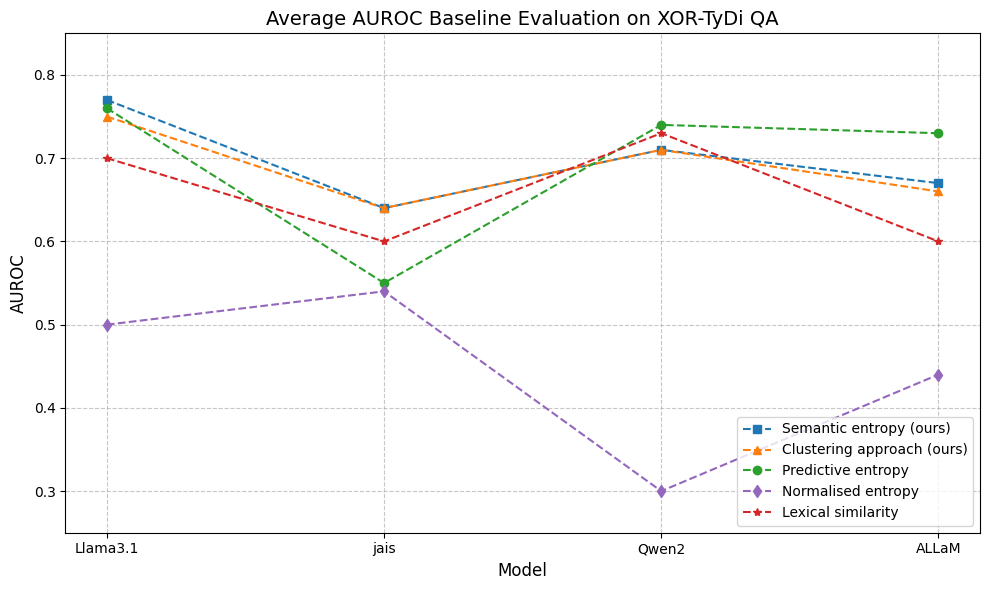

Average AUROC bar chart saved as 'average_aucroc_models_baseline.png'


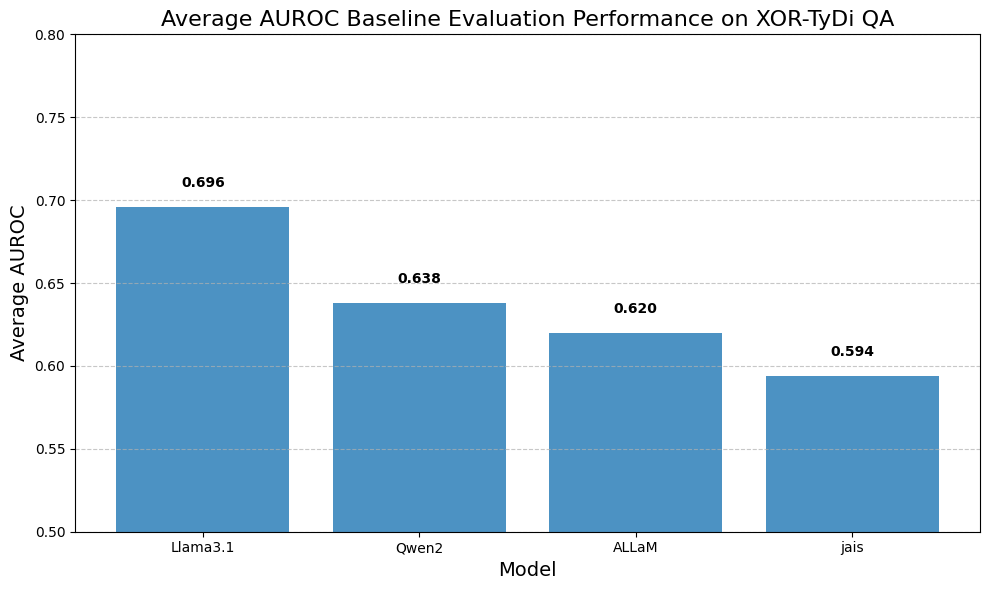

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manual entry of the data from the table
model_data = {
    'Model': ['Llama3.1', 'jais', 'Qwen2', 'ALLaM'],
    'SE': [0.77, 0.64, 0.71, 0.67],
    'Clustering approach': [0.75, 0.64, 0.71, 0.66],
    'Predictive Entropy': [0.76, 0.55, 0.74, 0.73],
    'Length Normalized Predictive Entropy': [0.50, 0.54, 0.30, 0.44],
    'Lexical Similarity': [0.70, 0.60, 0.73, 0.60]
}

# Create DataFrame
df = pd.DataFrame(model_data)

# Calculate average AUROC across all measures for each model
df['Average_AUROC'] = df[['SE', 'Clustering approach', 'Predictive Entropy',
                         'Length Normalized Predictive Entropy', 'Lexical Similarity']].mean(axis=1)

# Print the average AUROC for each model
print("Average AUROC performance per model:")
for i, model in enumerate(df['Model']):
    print(f"{model}: {df['Average_AUROC'][i]:.4f}")

# Sort models by their average performance (highest first)
df_sorted = df.sort_values(by='Average_AUROC', ascending=False)

# Create original line chart first
plt.figure(figsize=(10, 6))

# Plot each uncertainty measure as a separate line
plt.plot(df['Model'], df['SE'], marker='s', linestyle='--', color='#1f77b4', label='Semantic entropy (ours)')
plt.plot(df['Model'], df['Clustering approach'], marker='^', linestyle='--', color='#ff7f0e', label='Clustering approach (ours)')
plt.plot(df['Model'], df['Predictive Entropy'], marker='o', linestyle='--', color='#2ca02c', label='Predictive entropy')
plt.plot(df['Model'], df['Length Normalized Predictive Entropy'], marker='d', linestyle='--', color='#9467bd', label='Normalised entropy')
plt.plot(df['Model'], df['Lexical Similarity'], marker='*', linestyle='--', color='#d62728', label='Lexical similarity')

# Set plot details
plt.ylim([0.25, 0.85])
plt.xlabel('Model', fontsize=12)
plt.ylabel('AUROC', fontsize=12)
plt.title('Average AUROC Baseline Evaluation on XOR-TyDi QA', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='lower right')

# Ensure layout is tight
plt.tight_layout()

# Save plot with high resolution
plt.savefig('average_auroc_baseline.png.png', dpi=300, bbox_inches='tight')
print("Line chart saved as 'average_auroc_baseline.png'")

# Display the plot
plt.show()

# Now create a bar chart to clearly show the average performance per model
plt.figure(figsize=(10, 6))

# Create bar chart of average performance
bars = plt.bar(df_sorted['Model'], df_sorted['Average_AUROC'], color='#1f77b4', alpha=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Set y-axis to appropriate range
plt.ylim([0.5, 0.8])
plt.ylabel('Average AUROC', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.title('Average AUROC Baseline Evaluation Performance on XOR-TyDi QA', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure layout is tight
plt.tight_layout()

# Save plot
plt.savefig('average_aucroc_models_baseline.png', dpi=300, bbox_inches='tight')
print("Average AUROC bar chart saved as 'average_aucroc_models_baseline.png'")

plt.show()



# Average Barchart comparasion for all models and each uncertainty measure | Xor-TydiQA dataset

Bar chart for Semantic entropy (ours) saved as 'Average_Semantic_entropy_ours_by_models.png'


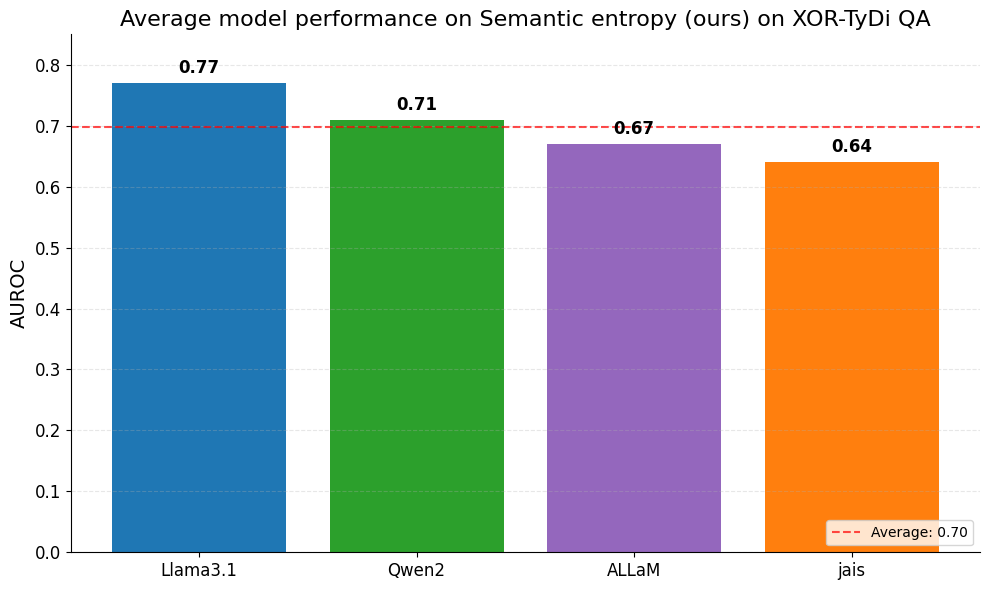

Bar chart for Clustering approach (ours) saved as 'Average_Clustering_approach_ours_by_models.png'


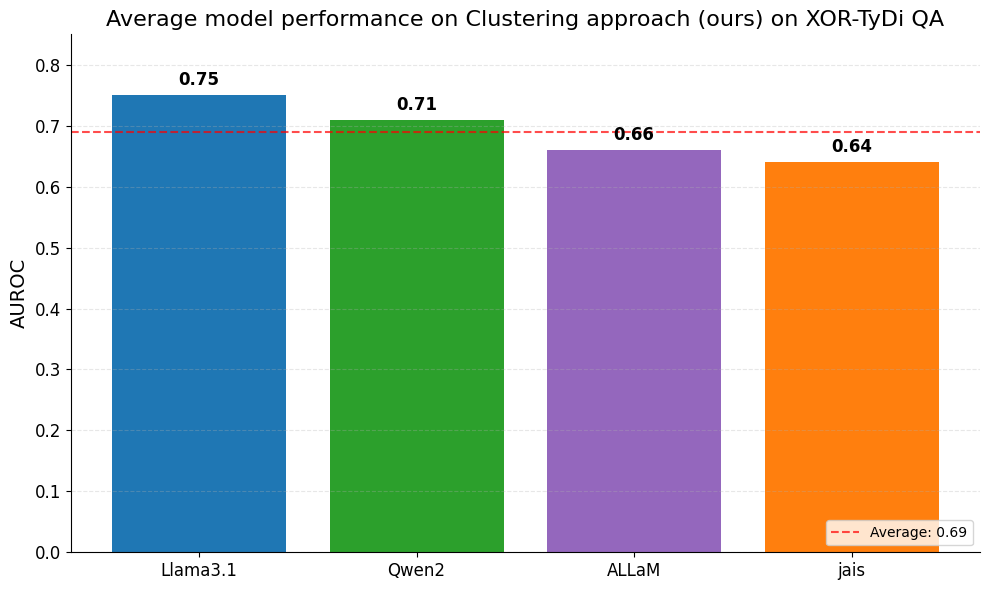

Bar chart for Predictive Entropy saved as 'Average_Predictive_Entropy_by_models.png'


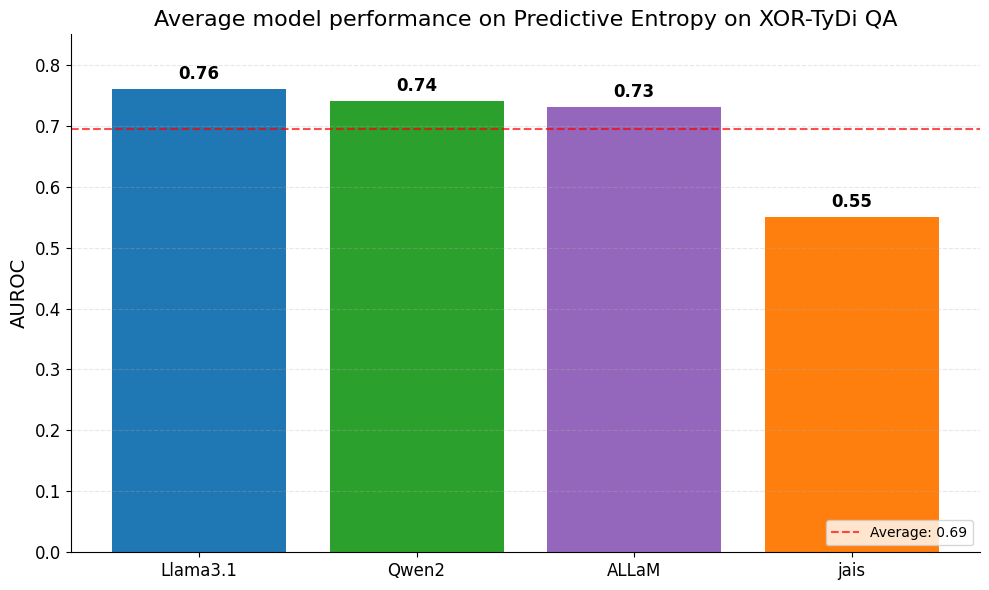

Bar chart for Normalised entropy saved as 'Average_Normalised_entropy_by_models.png'


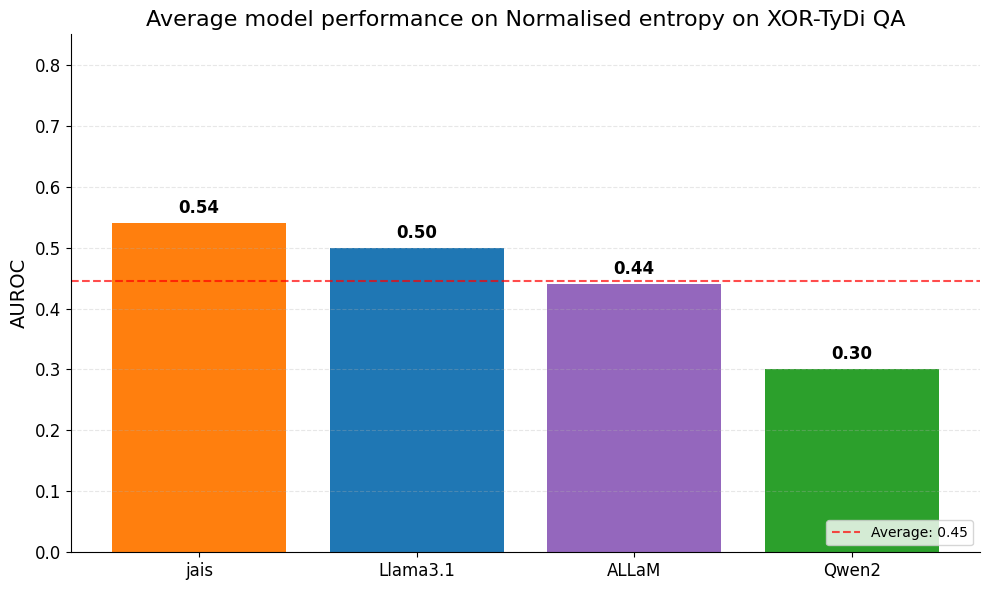

Bar chart for Lexical similarity saved as 'Average_Lexical_similarity_by_models.png'


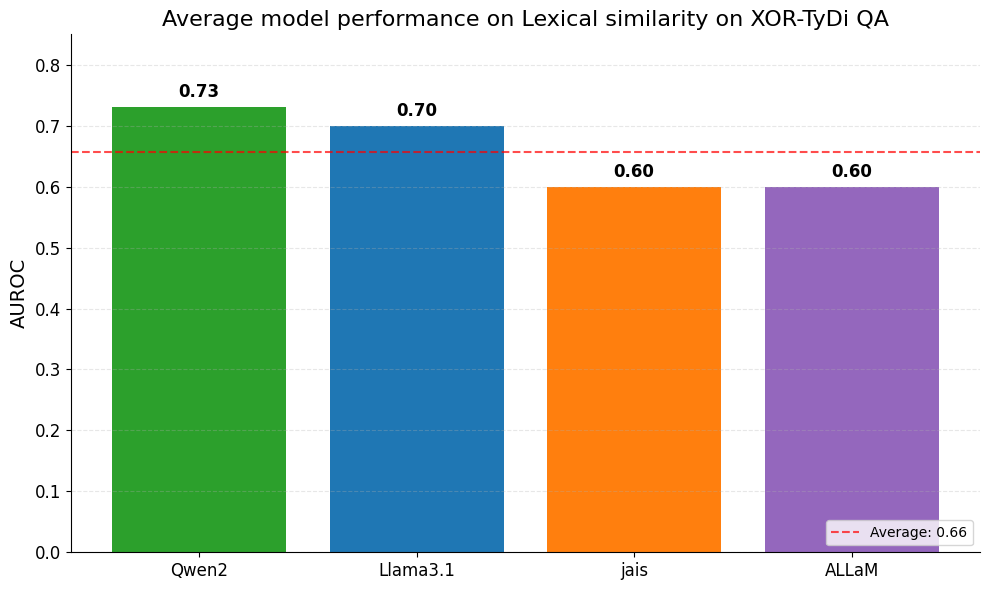

Average performance bar chart saved as 'average_barchart_baseline.png'


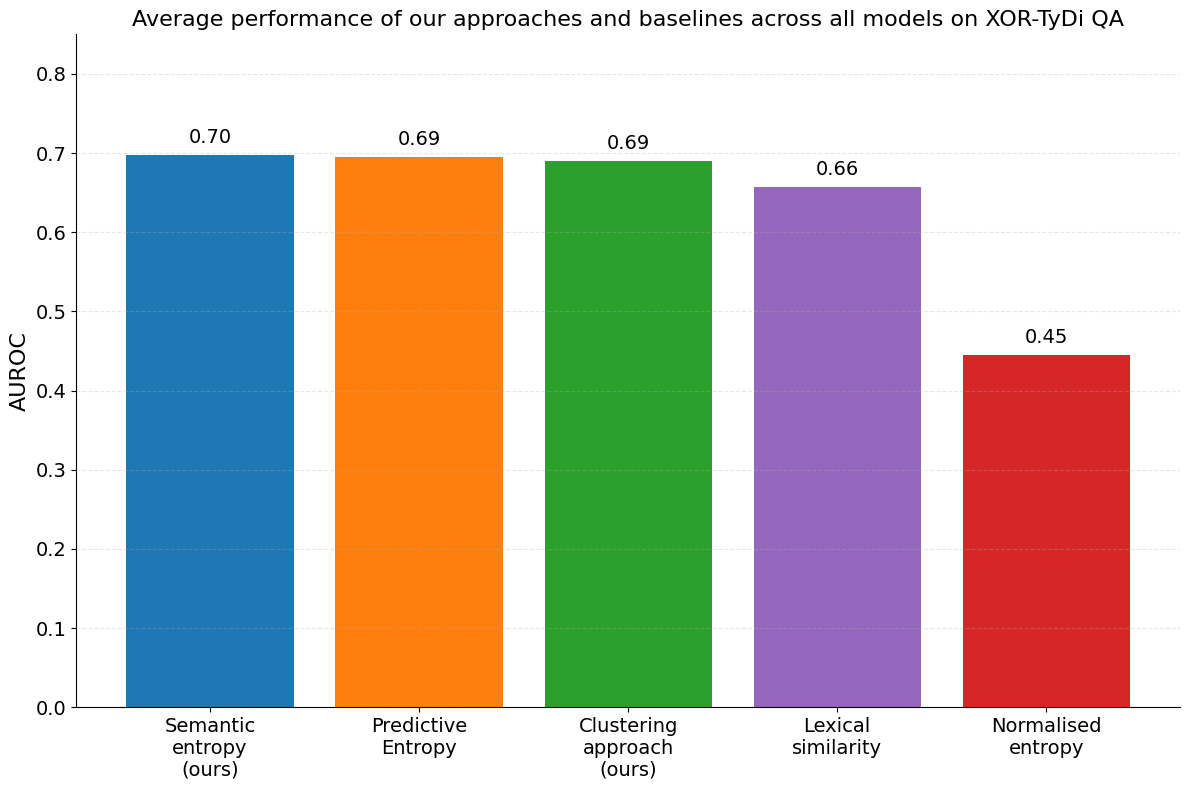

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the data from your table
model_data = {
    'Model': ['Llama3.1', 'jais', 'Qwen2', 'ALLaM'],
    'Number of parameters': ['8B', '7B', '7B', '7B'],
    'SE': [0.77, 0.64, 0.71, 0.67],
    'Clustering approach': [0.75, 0.64, 0.71, 0.66],
    'Predictive Entropy': [0.76, 0.55, 0.74, 0.73],
    'Length Normalized Predictive Entropy': [0.50, 0.54, 0.30, 0.44],
    'Lexical Similarity': [0.70, 0.60, 0.73, 0.60]
}

# Create DataFrame
df = pd.DataFrame(model_data)

# Create prettier labels with line breaks for the plot
measure_labels = {
    'SE': 'Semantic\nentropy\n(ours)',
    'Clustering approach': 'Clustering\napproach\n(ours)',
    'Predictive Entropy': 'Predictive\nEntropy',
    'Length Normalized Predictive Entropy': 'Normalised\nentropy',
    'Lexical Similarity': 'Lexical\nsimilarity'
}

# Map original measures to their prettier labels for plot titles
pretty_measures = {
    'SE': 'Semantic entropy (ours)',
    'Clustering approach': 'Clustering approach (ours)',
    'Predictive Entropy': 'Predictive Entropy',
    'Length Normalized Predictive Entropy': 'Normalised entropy',
    'Lexical Similarity': 'Lexical similarity'
}

# Define colors for the models
model_colors = {
    'Llama3.1': '#1f77b4',  # blue
    'jais': '#ff7f0e',      # orange
    'Qwen2': '#2ca02c',     # green
    'ALLaM': '#9467bd'      # purple
}

# Create a bar chart for each uncertainty measure
for measure in ['SE', 'Clustering approach', 'Predictive Entropy',
               'Length Normalized Predictive Entropy', 'Lexical Similarity']:

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Sort models by their performance on this measure (highest first)
    sorted_df = df.sort_values(by=measure, ascending=False)

    # Create the bar chart
    bars = plt.bar(sorted_df['Model'], sorted_df[measure],
                  color=[model_colors[model] for model in sorted_df['Model']])

    # Add a horizontal line for average
    avg_value = df[measure].mean()
    plt.axhline(y=avg_value, color='red', linestyle='--', alpha=0.7,
               label=f'Average: {avg_value:.2f}')

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Set the axis labels and limits - starting from 0
    plt.ylabel('AUROC', fontsize=14)
    plt.ylim([0, 0.85])

    # Add a title
    plt.title(f'Average model performance on {pretty_measures[measure]} on XOR-TyDi QA', fontsize=16)

    # Add legend for the average line
    plt.legend(loc='lower right')

    # Customize the grid
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Customize the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Remove the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Ensure layout is tight
    plt.tight_layout()

    # Create a clean filename by replacing spaces and parentheses
    clean_measure = pretty_measures[measure].replace(' ', '_').replace('(', '').replace(')', '')

    # Save the figure with high resolution
    plt.savefig(f'Average_{clean_measure}_by_models.png', dpi=300, bbox_inches='tight')
    print(f"Bar chart for {pretty_measures[measure]} saved as 'Average_{clean_measure}_by_models.png'")

    # Show the plot
    plt.show()

# Create the average performance bar chart starting from 0
plt.figure(figsize=(12, 8))

# Calculate average performance for each uncertainty measure
measures_for_plot = ['SE', 'Clustering approach', 'Predictive Entropy',
                    'Length Normalized Predictive Entropy', 'Lexical Similarity']
average_performance = {}
for measure in measures_for_plot:
    average_performance[measure] = df[measure].mean()

# Create a DataFrame for the averages
avg_df = pd.DataFrame({
    'Measure': list(average_performance.keys()),
    'Average AUROC': list(average_performance.values())
})

# Sort by average AUROC (highest first)
avg_df = avg_df.sort_values(by='Average AUROC', ascending=False)

# Apply the pretty labels
avg_df['Plot Label'] = avg_df['Measure'].map(measure_labels)

# Define colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']

# Create the bar chart
bars = plt.bar(avg_df['Plot Label'], avg_df['Average AUROC'], color=colors[:len(avg_df)])

# Set the axis labels and limits - starting from 0
plt.ylabel('AUROC', fontsize=16)
plt.ylim([0, 0.85])

# Add values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=14)

# Customize the grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Customize the ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a title
plt.title('Average performance of our approaches and baselines across all models on XOR-TyDi QA', fontsize=16)

# Ensure layout is tight
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('average_barchart_baseline.png', dpi=300, bbox_inches='tight')
print("Average performance bar chart saved as 'average_barchart_baseline.png'")

# Show the plot
plt.show()